# ML prep & application for allrecipes.com project

Use functions imported from another file.

## Properties:
- input = pandas dataframe with all recipe data
- output = ML predictions on avg rating / clustering (could also do number of ratings & reviews)

## Workflow
1. Clean up the df<br>
    - remove (largely) empty columns<br>
    - fill NA<br>
    - fix up formats (datetime, float, remove units etc)<br><br>
1. Deal with language<br>
    - remove stopwords<br>
    - stem<br>
    - tf-idf<br>
    - NMF<br>
    - describe each unit (word??) in terms of a few NMF components (eg two or three)<br><br>
1. One-hot-encode what's needed<br><br>
1. Predict number of stars / ratings / reviews<br>

## Import packages / setup

In [4]:
# import public things

# general / random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipynb
import re # for string parsing / editing
import string # for string parsing / editing
from datetime import datetime
import time
import random
from pathlib import Path
import os
import ast

# for html
import requests # for getting html off the web
from bs4 import BeautifulSoup # for parsing html
import json

# for ML
from wordcloud import WordCloud, STOPWORDS
import snowballstemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# import functions from my functions file
import ipynb.fs.full.functions as funcs

# update a module if it's been edited
# (this is just going around a jupyter feature where simply re-importing doesn't do anything)
# https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
import importlib
importlib.reload(funcs)

# other useful settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

## Clean up the df

In [5]:
# input the name (which is a timestamp) of the folder for the round of interest

input_timestamp = 'joint_2021-05-11_11-28'

In [6]:
# read in the dataframe with al the recipe info from Excel file
df = pd.read_excel(f'/home/bkotryna/Allrecipes/data/{input_timestamp}/processed_recipe_data.xlsx')

# set recipe_id as index
df.set_index('recipe_id', inplace=True)

# inspect
display(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            3391 non-null   object 
 1   date_published                   3391 non-null   object 
 2   description                      3391 non-null   object 
 3   avg_rating                       3391 non-null   float64
 4   ratings_no                       3391 non-null   int64  
 5   recipe_cats                      3391 non-null   object 
 6   5 stars                          3391 non-null   int64  
 7   4 stars                          3391 non-null   int64  
 8   3 stars                          3391 non-null   int64  
 9   2 stars                          3391 non-null   int64  
 10  1 star                           3391 non-null   int64  
 11  reviews_no                       3391 non-null   int64  
 12  video_present   

None

,title,date_published,description,avg_rating,ratings_no,recipe_cats,5 stars,4 stars,3 stars,2 stars,1 star,reviews_no,video_present,photo_count,prepTime,cookTime,totalTime,ingredients_no,ingredient_names,steps_no,steps_str,steps_words_no,nutrition.calories,nutrition.carbohydrateContent,nutrition.cholesterolContent,nutrition.fatContent,nutrition.fiberContent,nutrition.proteinContent,nutrition.saturatedFatContent,nutrition.servingSize,nutrition.sodiumContent,nutrition.sugarContent,nutrition.transFatContent,nutrition.unsaturatedFatContent
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,Pavlova,2019-04-04,My grandmother's recipe from New Zealand for t...,4.520000,25,"['Dessert Recipes', 'Specialty Dessert Recipes...",18,4,1,2,0,19,0,8,0,0,0,6,"['egg whites', 'distilled white vinegar', 'col...",4,Preheat oven to 300 degrees F (150 degrees C)....,102,108.1 calories,26 g,NaN,NaN,NaN,1.4 g,NaN,NaN,21.3 mg,25.2 g,NaN,NaN
10007,Evelyn's Cornflake Cookies,1997-09-26,I got this recipe from my ex mother-in-law ...,4.000000,8,"['Dessert Recipes', 'Cookies']",4,1,2,1,0,8,0,2,0,0,0,9,"['cream cheese', 'butter', 'white sugar', 'all...",3,Cream together all ingredients except cornflak...,56,195.6 calories,24.6 g,28.1 mg,10.3 g,0.5 g,2 g,6.4 g,NaN,198.6 mg,8.9 g,NaN,NaN
10014,Hazelnut Biscotti,1997-09-25,Twice-baked cookie that can have miniature cho...,4.428571,14,"['Dessert Recipes', 'Cookies', 'Nut Cookie Rec...",9,3,1,1,0,12,0,4,0,0,0,10,"['skinned toasted hazelnuts', 'white sugar', '...",4,Preheat oven to 350 degrees F (180 degrees C)....,132,259 calories,33.1 g,44.6 mg,12.2 g,1.6 g,4.6 g,4.7 g,NaN,100 mg,15.5 g,NaN,NaN
10019,Chocolate Peanut Butter Bars II,1997-09-30,No-bake peanut butter bars.,4.627551,196,"['Dessert Recipes', 'Cookies', 'Peanut Butter ...",150,31,8,2,5,156,0,20,0,0,0,6,"['butter', 'packed brown sugar', 'vanilla extr...",3,Melt butter or margarine over low heat. Add su...,32,587.9 calories,60 g,20.3 mg,37.8 g,4.2 g,12.1 g,14.4 g,NaN,257.8 mg,52.6 g,NaN,NaN
10022,Pignoli Cookies I,1997-10-05,"They are pleasantly sweet, made with almond pa...",4.415301,183,"['World Cuisine Recipes', 'European', 'Italian']",135,20,10,5,13,146,0,14,30,18,70,5,"['almond paste', 'white sugar', 'confectioners...",4,Preheat oven to 325 degrees F (165 degrees C)....,121,100.9 calories,11.4 g,NaN,5.5 g,0.7 g,2.6 g,0.7 g,NaN,7.3 mg,6.2 g,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87484,German Lemon Cake,2020-06-19,This loaf cake is known in Germany as 'Zitrone...,3.796296,54,"['World Cuisine Recipes', 'European', 'German']",22,14,8,5,5,45,0,7,20,75,95,8,"['butter softened', 'white sugar', 'eggs', 'ru...",4,Preheat the oven to 350 degrees (175 degrees C...,138,391.9 calories,49.7 g,123.3 mg,19.4 g,0.4 g,3.9 g,11.6 g,NaN,153.1 mg,31.4 g,NaN,NaN
91192,French Onion Soup Gratinee,2019-04-02,About as good as it gets! This is the version ...,4.741086,1823,"['Soups, Stews and Chili Recipes', 'Soup Recip...",1493,238,55,24,13,1251,1,316,15,60,75,17,"['butter', 'salt', 'red onions thinly', 'sweet...",5,Melt butter in a large pot over medium-high he...,210,617.8 calories,39.5 g,113.9 mg,35.9 g,4.2 g,29.7 g,20.8 g,NaN,3335.7 mg,10.6 g,NaN,NaN
9524,Dutch Cookies,1999-12-08,This recipe has become a cherished family favo...,4.387097,31,"['World Cuisine Recipes', 'European', 'Dutch']",18,9,3,0,1,26,0,7,0,0,0,8,"['butter', 'shortening', 'white sugar', 'all-p...",5,Preheat oven to 350 F (175 degrees C). Cream t...,121,106.6 calories,12.5 g,6.1 mg,6.1 g,0.5 g,1 g,2.9 g,NaN,32.2 mg,7.5 g,NaN,NaN


In [7]:
# drop empty columns

# BTW could use this to get rid of specific columns:
# df.drop([''], axis=1, inplace=True)

# drop columns that are all NA
df.dropna(axis=1, how='all', inplace=True)

# re-inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   title                          3391 non-null   object 
 1   date_published                 3391 non-null   object 
 2   description                    3391 non-null   object 
 3   avg_rating                     3391 non-null   float64
 4   ratings_no                     3391 non-null   int64  
 5   recipe_cats                    3391 non-null   object 
 6   5 stars                        3391 non-null   int64  
 7   4 stars                        3391 non-null   int64  
 8   3 stars                        3391 non-null   int64  
 9   2 stars                        3391 non-null   int64  
 10  1 star                         3391 non-null   int64  
 11  reviews_no                     3391 non-null   int64  
 12  video_present                  3391 non-null

## Dealing with publication date

In [8]:
# convert date_published from str to datetime

# first, inspect
display(type(df.iloc[0]['date_published']))

# then, convert
df['date_published'] =  pd.to_datetime(df['date_published'])

# then, re-inspect
type(df.iloc[0]['date_published'])

str

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
# add recipe_age (ie time since publication) column, drop date_published column

# define what date is today (roughly)
# could use datetime.datetime.now() if wanted to have up-to-date "today", but I figure I'd rather have fixed number here atm
datetime_today = datetime(2021, 4, 27)
print(datetime_today)

# calculate recipe age
df['recipe_age'] = df['date_published'] - datetime_today
# convert recipe age to an integer number of days (I think it's always rounding down)
df['recipe_age'] = df['recipe_age'].apply(lambda x: -x.days)

# drop the original date_published column
df.drop('date_published', axis=1, inplace=True)

# inspect
display(df['recipe_age'])
display(df.info())

2021-04-27 00:00:00


recipe_id
10004     754
10007    8614
10014    8615
10019    8610
10022    8605
         ... 
87484     312
91192     756
9524     7811
9800     4684
9954     4684
Name: recipe_age, Length: 3391, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   title                          3391 non-null   object 
 1   description                    3391 non-null   object 
 2   avg_rating                     3391 non-null   float64
 3   ratings_no                     3391 non-null   int64  
 4   recipe_cats                    3391 non-null   object 
 5   5 stars                        3391 non-null   int64  
 6   4 stars                        3391 non-null   int64  
 7   3 stars                        3391 non-null   int64  
 8   2 stars                        3391 non-null   int64  
 9   1 star                         3391 non-null   int64  
 10  reviews_no                     3391 non-null   int64  
 11  video_present                  3391 non-null   int64  
 12  photo_count                    3391 non-null

None

## Transform recipe_cats & ingredient_names columns from lists to comma-separated strings

In [10]:
# transform recipe_cats & ingredient_names columns. Each cell goes from a list into a comma-seprated string

# recipe_cats
df['recipe_cats_str'] = df['recipe_cats'].apply(lambda x: x[1:-1])
df['recipe_cats_str'] = df['recipe_cats_str'].apply(lambda x: x.replace("'", ""))
display(df['recipe_cats_str'])

# ingredient_names
df['ingredient_names_str'] = df['ingredient_names'].apply(lambda x: x[1:-1])
df['ingredient_names_str'] = df['ingredient_names_str'].apply(lambda x: x.replace("'", ""))
display(df['ingredient_names_str'])

# alternative - gives a string, rather than individual strings separated by commas, as far as I can tell
# recipes_df['ingredient_names'] = recipes_df['ingredient_names'].apply(lambda x: ', '.join([str(i) for i in x]))

recipe_id
10004    Dessert Recipes, Specialty Dessert Recipes, Pa...
10007                             Dessert Recipes, Cookies
10014    Dessert Recipes, Cookies, Nut Cookie Recipes, ...
10019    Dessert Recipes, Cookies, Peanut Butter Cookie...
10022             World Cuisine Recipes, European, Italian
                               ...                        
87484              World Cuisine Recipes, European, German
91192    Soups, Stews and Chili Recipes, Soup Recipes, ...
9524                World Cuisine Recipes, European, Dutch
9800                World Cuisine Recipes, European, Dutch
9954               World Cuisine Recipes, European, French
Name: recipe_cats_str, Length: 3391, dtype: object

recipe_id
10004    egg whites, distilled white vinegar, cold wate...
10007    cream cheese, butter, white sugar, all-purpose...
10014    skinned toasted hazelnuts, white sugar, unsalt...
10019    butter, packed brown sugar, vanilla extract, p...
10022    almond paste, white sugar, confectioners sugar...
                               ...                        
87484    butter softened, white sugar, eggs, rum, all-p...
91192    butter, salt, red onions thinly, sweet onions ...
9524     butter, shortening, white sugar, all-purpose f...
9800     butter, white sugar, all-purpose flour, cinnam...
9954     eggs, vanilla extract, salt, white sugar, all-...
Name: ingredient_names_str, Length: 3391, dtype: object

## Convert recipe category lists into columns of one-hot encoding

In [11]:
# convert recipe_cats string into list
df["recipe_cats_list"]  = df["recipe_cats"].apply(ast.literal_eval)

# could expand lists into separate columns if desired
#test_df = df['recipe_cats_list'].apply(pd.Series).add_prefix('cats_')

# extract unique values from recipe_cats
unique_values = []
for index, row in df['recipe_cats_list'].iteritems():
    for item in row:
        if item not in unique_values:
            unique_values.append(item)
display(unique_values)

# make a new cat_df for manual one-hot encoding (will append this to the master df when done)
cat_df = pd.DataFrame(columns = unique_values, index=df.index)
display(cat_df)            

['Dessert Recipes',
 'Specialty Dessert Recipes',
 'Pavlova Recipes',
 'Cookies',
 'Nut Cookie Recipes',
 'Hazelnut',
 'Peanut Butter Cookie Recipes',
 'World Cuisine Recipes',
 'European',
 'Italian',
 'Drop Cookie Recipes',
 'Filled Cookie Recipes',
 'Nut Dessert Recipes',
 'Pecan Dessert Recipes',
 'No-Bake Cookie Recipes',
 'Fruit Dessert Recipes',
 'Cherry Dessert Recipes',
 'Frostings and Icings',
 'Cookie Frosting',
 'Fruit Cookie Recipes',
 'Coconut',
 'Brownie Recipes',
 'Chocolate Brownie Recipes',
 'Bar Cookie Recipes',
 'International Cookie Recipes',
 'American Cookie Recipes',
 'Fruits and Vegetables',
 'Vegetables',
 'Squash',
 'Butter Cookie Recipes',
 'Shortbread Cookie Recipes',
 'UK and Ireland',
 'Welsh',
 'Cut-Out Cookie Recipes',
 '100+ Breakfast and Brunch Recipes',
 'Sugar Cookie Recipes',
 'Dutch',
 'Almond Dessert Recipes',
 'Spice Cookie Recipes',
 'Irish',
 'Date',
 'Apricot',
 'Scandinavian',
 'Refrigerator Cookie Recipes',
 'German',
 'Chocolate Dessert Re

,Dessert Recipes,Specialty Dessert Recipes,Pavlova Recipes,Cookies,Nut Cookie Recipes,Hazelnut,Peanut Butter Cookie Recipes,World Cuisine Recipes,European,Italian,Drop Cookie Recipes,Filled Cookie Recipes,Nut Dessert Recipes,Pecan Dessert Recipes,No-Bake Cookie Recipes,Fruit Dessert Recipes,Cherry Dessert Recipes,Frostings and Icings,Cookie Frosting,Fruit Cookie Recipes,Coconut,Brownie Recipes,Chocolate Brownie Recipes,Bar Cookie Recipes,International Cookie Recipes,American Cookie Recipes,Fruits and Vegetables,Vegetables,Squash,Butter Cookie Recipes,Shortbread Cookie Recipes,UK and Ireland,Welsh,Cut-Out Cookie Recipes,100+ Breakfast and Brunch Recipes,Sugar Cookie Recipes,Dutch,Almond Dessert Recipes,Spice Cookie Recipes,Irish,Date,Apricot,Scandinavian,Refrigerator Cookie Recipes,German,Chocolate Dessert Recipes,Milk Chocolate,Latin American,Mexican,Chocolate,Bread,Quick Bread Recipes,Liqueur Dessert Recipes,Coffee Liqueur,Thumbprint Cookie Recipes,Raisin,Chocolate Chip Cookie Recipes,Macaroon Recipes,Apple Dessert Recipes,Banana Dessert Recipes,Meat and Poultry Recipes,Pork,Sausage,Salad,100+ Pasta Salad Recipes,Vegetarian Pasta Salad Recipes,100+ Everyday Cooking Recipes,Vegetarian,Side Dishes,Appetizers and Snacks,Pasta Appetizer Recipes,Main Dish Recipes,Dumpling Recipes,Seafood,Fish,Salmon,Smoked,"Soups, Stews and Chili Recipes",Stews,Goulash Recipes,Spaghetti Pasta Salad Recipes,Side Dish,Chicken,Chicken Breast Recipes,Pasta,Sauces and Condiments Recipes,Sauce Recipes,Pasta Sauce Recipes,Tomato,Pies,No-Bake Pie Recipes,Pudding Pie Recipes,Custard and Cream Pie Recipes,Cakes,Cheesecake Recipes,Meringue Pie Recipes,Apple Pie Recipes,Strawberry Dessert Recipes,100+ Pie Crust Recipes,Crumb Crusts,Pineapple Pie,Vintage Pie Recipes,Fruit Pie Recipes,Rhubarb Pie Recipes,Blueberry Pie Recipes,Chocolate Pie Recipes,Coconut Pie Recipes,Pastry Crusts,Savory Pie Recipes,Peach Dessert Recipes,Banana Pie Recipes,Seafood Main Dish Recipes,Clams,Halibut,Canapes and Crostini Recipes,Shrimp,Shellfish,Crab,Fish Cake Recipes,Seafood Salad Recipes,Shrimp Salad Recipes,Soup Recipes,Chicken Soup Recipes,Chicken Noodle Soup Recipes,Noodle Soup Recipes,Vegetable Soup Recipes,Barley Soup Recipes,Cream Soup Recipes,Cream of Mushroom Soup Recipes,Beans and Peas,Cream of Broccoli Soup,Onion Soup Recipes,French Onion Soup Recipes,Potato Soup Recipes,Chili Recipes,Beef Chili Recipes,Cream of Potato Soup Recipes,Stuffing and Dressing Recipes,Vegetarian Stuffing and Dressing Recipes,Dips and Spreads Recipes,Cheese Dips and Spreads Recipes,Cream Cheese Spreads Recipes,Cornbread Recipes,Cranberry Dessert Recipes,Fruit Bread Recipes,Cranberry Bread Recipes,Waldorf Salad Recipes,Pecan Pie Recipes,Casseroles,Broccoli Casserole Recipes,Potato Side Dish Recipes,Spinach Casserole,Oyster Stuffing and Dressing,Pickled Egg Recipes,Dessert Salad Recipes,Jell-O® Salad,Pancake Recipes,Whole Grain Pancake Recipes,Vegetable Salad Recipes,Lasagna Recipes,Zucchini Lasagna Recipes,Vegetable,Mushrooms,Stuffed Mushroom Recipes,Asian,Indian,Chinese,Grain Side Dish Recipes,Polenta Recipes,French Toast Recipes,Salsa Recipes,Tomato Salsa Recipes,Rice,Risotto Recipes,Fruit Salad Recipes,Strawberry Salad Recipes,Broccoli Salad Recipes,Tuna Salad Recipes,Coleslaw Recipes,No Mayo,Green Salad Recipes,Romaine Lettuce Salad Recipes,Salad Dressing Recipes,Honey Dressing Recipes,Beans,Vinaigrette Dressing Recipes,Italian Pasta Salad Recipes,Spinach Salad Recipes,Asparagus Salad Recipes,Mixed Greens Salad Recipes,Avocado Salad Recipes,Sour Cream Dressing Recipes,Pork Chop Recipes,Onion,Lamb,Chops,Marinade Recipes,Stuffed Main Dish Recipes,Stuffed Cabbage,Beef,Steaks,Flank Steak Recipes,Round Steak Recipes,Pot Roast Recipes,Beef Stroganoff Recipes,Pot Pie Recipes,French,Ham,Sandwich Recipes,Pork Tenderloin Recipes,Olives,Pizza Recipes,Spinach Dip Recipes,Snacks,Cracker Recipes,Wraps and Rolls,Hummus Recipes,Tomatoes,Lemon Dessert Recipes,Broccoli Soup Recipes,Tuna,Cake Mix Cake Recipes,Y

In [12]:
# manually one-hot encode

# add 1 if recipe belongs to a particular category
for index, row in df['recipe_cats_list'].iteritems():
    for item in row:
        for col_name in cat_df.columns:
            if item == col_name:
                cat_df.at[index, col_name] = 1

display(cat_df.info())

# replace the remaining empty (NaN) cells with zeros
cat_df.fillna(0, inplace=True)
display(cat_df.info())
display(cat_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Columns: 714 entries, Dessert Recipes to Veggie
dtypes: object(714)
memory usage: 18.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Columns: 714 entries, Dessert Recipes to Veggie
dtypes: int64(714)
memory usage: 18.7 MB


None

,Dessert Recipes,Specialty Dessert Recipes,Pavlova Recipes,Cookies,Nut Cookie Recipes,Hazelnut,Peanut Butter Cookie Recipes,World Cuisine Recipes,European,Italian,Drop Cookie Recipes,Filled Cookie Recipes,Nut Dessert Recipes,Pecan Dessert Recipes,No-Bake Cookie Recipes,Fruit Dessert Recipes,Cherry Dessert Recipes,Frostings and Icings,Cookie Frosting,Fruit Cookie Recipes,Coconut,Brownie Recipes,Chocolate Brownie Recipes,Bar Cookie Recipes,International Cookie Recipes,American Cookie Recipes,Fruits and Vegetables,Vegetables,Squash,Butter Cookie Recipes,Shortbread Cookie Recipes,UK and Ireland,Welsh,Cut-Out Cookie Recipes,100+ Breakfast and Brunch Recipes,Sugar Cookie Recipes,Dutch,Almond Dessert Recipes,Spice Cookie Recipes,Irish,Date,Apricot,Scandinavian,Refrigerator Cookie Recipes,German,Chocolate Dessert Recipes,Milk Chocolate,Latin American,Mexican,Chocolate,Bread,Quick Bread Recipes,Liqueur Dessert Recipes,Coffee Liqueur,Thumbprint Cookie Recipes,Raisin,Chocolate Chip Cookie Recipes,Macaroon Recipes,Apple Dessert Recipes,Banana Dessert Recipes,Meat and Poultry Recipes,Pork,Sausage,Salad,100+ Pasta Salad Recipes,Vegetarian Pasta Salad Recipes,100+ Everyday Cooking Recipes,Vegetarian,Side Dishes,Appetizers and Snacks,Pasta Appetizer Recipes,Main Dish Recipes,Dumpling Recipes,Seafood,Fish,Salmon,Smoked,"Soups, Stews and Chili Recipes",Stews,Goulash Recipes,Spaghetti Pasta Salad Recipes,Side Dish,Chicken,Chicken Breast Recipes,Pasta,Sauces and Condiments Recipes,Sauce Recipes,Pasta Sauce Recipes,Tomato,Pies,No-Bake Pie Recipes,Pudding Pie Recipes,Custard and Cream Pie Recipes,Cakes,Cheesecake Recipes,Meringue Pie Recipes,Apple Pie Recipes,Strawberry Dessert Recipes,100+ Pie Crust Recipes,Crumb Crusts,Pineapple Pie,Vintage Pie Recipes,Fruit Pie Recipes,Rhubarb Pie Recipes,Blueberry Pie Recipes,Chocolate Pie Recipes,Coconut Pie Recipes,Pastry Crusts,Savory Pie Recipes,Peach Dessert Recipes,Banana Pie Recipes,Seafood Main Dish Recipes,Clams,Halibut,Canapes and Crostini Recipes,Shrimp,Shellfish,Crab,Fish Cake Recipes,Seafood Salad Recipes,Shrimp Salad Recipes,Soup Recipes,Chicken Soup Recipes,Chicken Noodle Soup Recipes,Noodle Soup Recipes,Vegetable Soup Recipes,Barley Soup Recipes,Cream Soup Recipes,Cream of Mushroom Soup Recipes,Beans and Peas,Cream of Broccoli Soup,Onion Soup Recipes,French Onion Soup Recipes,Potato Soup Recipes,Chili Recipes,Beef Chili Recipes,Cream of Potato Soup Recipes,Stuffing and Dressing Recipes,Vegetarian Stuffing and Dressing Recipes,Dips and Spreads Recipes,Cheese Dips and Spreads Recipes,Cream Cheese Spreads Recipes,Cornbread Recipes,Cranberry Dessert Recipes,Fruit Bread Recipes,Cranberry Bread Recipes,Waldorf Salad Recipes,Pecan Pie Recipes,Casseroles,Broccoli Casserole Recipes,Potato Side Dish Recipes,Spinach Casserole,Oyster Stuffing and Dressing,Pickled Egg Recipes,Dessert Salad Recipes,Jell-O® Salad,Pancake Recipes,Whole Grain Pancake Recipes,Vegetable Salad Recipes,Lasagna Recipes,Zucchini Lasagna Recipes,Vegetable,Mushrooms,Stuffed Mushroom Recipes,Asian,Indian,Chinese,Grain Side Dish Recipes,Polenta Recipes,French Toast Recipes,Salsa Recipes,Tomato Salsa Recipes,Rice,Risotto Recipes,Fruit Salad Recipes,Strawberry Salad Recipes,Broccoli Salad Recipes,Tuna Salad Recipes,Coleslaw Recipes,No Mayo,Green Salad Recipes,Romaine Lettuce Salad Recipes,Salad Dressing Recipes,Honey Dressing Recipes,Beans,Vinaigrette Dressing Recipes,Italian Pasta Salad Recipes,Spinach Salad Recipes,Asparagus Salad Recipes,Mixed Greens Salad Recipes,Avocado Salad Recipes,Sour Cream Dressing Recipes,Pork Chop Recipes,Onion,Lamb,Chops,Marinade Recipes,Stuffed Main Dish Recipes,Stuffed Cabbage,Beef,Steaks,Flank Steak Recipes,Round Steak Recipes,Pot Roast Recipes,Beef Stroganoff Recipes,Pot Pie Recipes,French,Ham,Sandwich Recipes,Pork Tenderloin Recipes,Olives,Pizza Recipes,Spinach Dip Recipes,Snacks,Cracker Recipes,Wraps and Rolls,Hummus Recipes,Tomatoes,Lemon Dessert Recipes,Broccoli Soup Recipes,Tuna,Cake Mix Cake Recipes,Y

## Convert nutrition specs into float (strings with calories, g, mg => float)

In [13]:
# convert nutrition specs into float (strings with calories, g, mg => float)

df = funcs.remove_units(df, 'nutrition.calories', 'calories')
df = funcs.remove_units(df, 'nutrition.carbohydrateContent', 'g')
df = funcs.remove_units(df, 'nutrition.fatContent', 'g')
df = funcs.remove_units(df, 'nutrition.fiberContent', 'g')
df = funcs.remove_units(df, 'nutrition.proteinContent', 'g')
df = funcs.remove_units(df, 'nutrition.saturatedFatContent', 'g')
df = funcs.remove_units(df, 'nutrition.cholesterolContent', 'mg')
df = funcs.remove_units(df, 'nutrition.sodiumContent', 'mg')
df = funcs.remove_units(df, 'nutrition.sugarContent', 'g')

Now removing units from column:  nutrition.calories
Now removing units from column:  nutrition.carbohydrateContent
Now removing units from column:  nutrition.fatContent
Now removing units from column:  nutrition.fiberContent
Now removing units from column:  nutrition.proteinContent
Now removing units from column:  nutrition.saturatedFatContent
Now removing units from column:  nutrition.cholesterolContent
Now removing units from column:  nutrition.sodiumContent
Now removing units from column:  nutrition.sugarContent


In [14]:
# inspect
pd.set_option('display.max_rows', 5)
display(df)

# inspect some more
pd.set_option('display.max_rows', 100)
display(df.info())

,title,description,avg_rating,ratings_no,recipe_cats,5 stars,4 stars,3 stars,2 stars,1 star,reviews_no,video_present,photo_count,prepTime,cookTime,totalTime,ingredients_no,ingredient_names,steps_no,steps_str,steps_words_no,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,recipe_age,recipe_cats_str,ingredient_names_str,recipe_cats_list
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,Pavlova,My grandmother's recipe from New Zealand for t...,4.520000,25,"['Dessert Recipes', 'Specialty Dessert Recipes...",18,4,1,2,0,19,0,8,0,0,0,6,"['egg whites', 'distilled white vinegar', 'col...",4,Preheat oven to 300 degrees F (150 degrees C)....,102,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2,754,"Dessert Recipes, Specialty Dessert Recipes, Pa...","egg whites, distilled white vinegar, cold wate...","[Dessert Recipes, Specialty Dessert Recipes, P..."
10007,Evelyn's Cornflake Cookies,I got this recipe from my ex mother-in-law ...,4.000000,8,"['Dessert Recipes', 'Cookies']",4,1,2,1,0,8,0,2,0,0,0,9,"['cream cheese', 'butter', 'white sugar', 'all...",3,Cream together all ingredients except cornflak...,56,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9,8614,"Dessert Recipes, Cookies","cream cheese, butter, white sugar, all-purpose...","[Dessert Recipes, Cookies]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,Dutch Cinnamon Biscuits,Tender with a spicy flavor.,2.750000,4,"['World Cuisine Recipes', 'European', 'Dutch']",0,1,2,0,1,4,0,1,0,0,0,7,"['butter', 'white sugar', 'all-purpose flour',...",3,Preheat oven to 350 degrees F (175 degrees C)....,92,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4,4684,"World Cuisine Recipes, European, Dutch","butter, white sugar, all-purpose flour, cinnam...","[World Cuisine Recipes, European, Dutch]"
9954,French Butter Cakes (Madeleines),Sponge cake cookie--in shell shaped molds.,4.520635,315,"['World Cuisine Recipes', 'European', 'French']",219,62,20,7,7,247,1,137,0,0,0,8,"['eggs', 'vanilla extract', 'salt', 'white sug...",9,Preheat oven to 375 degrees F (190 degrees C)....,202,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2,4684,"World Cuisine Recipes, European, French","eggs, vanilla extract, salt, white sugar, all-...","[World Cuisine Recipes, European, French]"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

## Handle language (TF-IDF, NMF etc)

### Loop through a list of columns

In [15]:
# import things

import snowballstemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF

In [16]:
# generate a master nmf_df
nmf_df = pd.DataFrame(index=df.index)

# choose columns for NMF analysis
columns_for_nmf = ['title', 'description', 'ingredient_names_str', 'steps_str']

# do NMF analysis
for col in columns_for_nmf:
    col_nmf_df = funcs.stem_make_nmf(col, df, nmf_df, n=4)
    nmf_df = pd.concat([nmf_df, col_nmf_df], axis=1)


************
Now working on column 'title':
Stemming done
vocabulary size: 2170
Tokenising done.
Most freqeunt words are:
[('chicken', 232), ('cooki', 189), ('cake', 189), ('chocol', 146), ('salad', 145)]
NMF transforming done.

***
Component 0 for title

Most important words are:
chicken : 4.560
salad : 0.863
fri : 0.281
easi : 0.259
curri : 0.213

The entry that most strongly embodies this component is:
Chicken Fried Chicken

***
Component 1 for title

Most important words are:
cooki : 3.151
chocol : 1.772
chip : 0.825
butter : 0.460
peanut : 0.411

The entry that most strongly embodies this component is:
Naughty Chocolate and Peanut Butter Chip Cookies

***
Component 2 for title

Most important words are:
cake : 3.332
chocol : 0.551
coffe : 0.284
pound : 0.260
apple : 0.245

The entry that most strongly embodies this component is:
Chocolate Fudge Pound Cake

***
Component 3 for title

Most important words are:
soup : 2.465
sauc : 1.006
chees : 0.940
potato : 0.901
cream : 0.701

Th

In [17]:
nmf_df

,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3
recipe_id,,,,,,,,,,,,,,,,
10004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182498,0.000000,0.000954,0.186797,0.014902,0.000000,0.118254,0.000000,0.369173,0.068182
10007,0.000000,0.216510,0.000000,0.000000,0.000000,0.000000,0.194772,0.000000,0.009689,0.287205,0.000000,0.130703,0.000000,0.000000,0.237319,0.231306
10014,0.000000,0.000734,0.001738,0.000482,0.014535,0.000000,0.000000,0.244313,0.016162,0.310287,0.000000,0.011195,0.080585,0.000000,0.421998,0.361768
10019,0.000000,0.182652,0.049741,0.000543,0.001244,0.002643,0.004298,0.007883,0.000000,0.276475,0.000000,0.025239,0.116150,0.041657,0.000000,0.000000
10022,0.000000,0.215566,0.000000,0.000000,0.000831,0.007082,0.003239,0.018145,0.000000,0.196305,0.000000,0.000000,0.081440,0.000000,0.312283,0.485409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87484,0.001262,0.000000,0.302626,0.000000,0.007888,0.000000,0.000000,0.069314,0.000000,0.306062,0.022891,0.006867,0.430003,0.000000,0.338872,0.000000
91192,0.000000,0.000000,0.000000,0.243566,0.279985,0.000000,0.002330,0.000000,0.203910,0.000000,0.393404,0.272970,0.054709,0.659722,0.277842,0.029501
9524,0.000000,0.217463,0.000000,0.000000,0.031292,0.012266,0.256575,0.018018,0.002753,0.332218,0.000000,0.000000,0.177104,0.000000,0.253640,0.314320


In [18]:
# inspect output

display(df.info())
display(df.describe())

pd.set_option('display.max_rows', 5)
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

,avg_rating,ratings_no,5 stars,4 stars,3 stars,2 stars,1 star,reviews_no,video_present,photo_count,prepTime,cookTime,totalTime,ingredients_no,steps_no,steps_words_no,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,recipe_age
count,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3385.000000,2909.000000,3340.000000,3267.000000,3371.000000,3254.000000,3388.000000,3355.000000,3391.000000
mean,4.198652,158.556178,105.787968,35.176644,10.368033,3.991448,3.232085,119.623120,0.083161,15.745798,18.343851,36.931584,82.878502,8.802123,3.000295,93.290770,325.123975,30.421595,69.248848,16.886886,2.433303,13.147019,6.726460,549.599469,13.101192,2236.889413
std,0.551400,496.474213,369.405531,92.585773,26.441669,10.917669,10.042452,358.697786,0.276167,51.255537,27.788726,69.313397,127.632735,3.632540,1.338008,51.851408,215.527660,22.839790,72.920589,15.243779,2.614344,13.948064,6.735404,2085.346526,15.140596,2927.469689
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,28.000000
25%,4.000000,15.000000,7.000000,4.000000,1.000000,0.000000,0.000000,12.000000,0.000000,1.000000,10.000000,8.000000,25.000000,6.000000,2.000000,59.000000,164.900000,12.800000,18.600000,6.000000,0.700000,2.700000,2.000000,110.150000,2.900000,418.000000
50%,4.333333,41.000000,22.000000,11.000000,4.000000,1.000000,1.000000,33.000000,0.000000,4.000000,15.000000,20.000000,45.000000,8.000000,3.000000,87.000000,286.600000,26.100000,49.500000,13.150000,1.600000,7.100000,4.800000,306.600000,7.100000,756.000000
75%,4.544261,112.000000,69.000000,29.000000,9.000000,4.000000,3.000000,89.000000,0.000000,11.000000,20.000000,40.000000,80.000000,11.000000,4.000000,116.000000,440.700000,43.300000,93.800000,24.100000,3.300000,21.000000,9.500000,706.925000,18.000000,1133.000000
max,5.000000,13382.000000,9796.000000,2073.000000,755.000000,373.000000,385.000000,10043.000000,1.000000,1433.000000,720.000000,1080.000000,1440.000000,33.000000,13.000000,723.000000,2020.200000,216.200000,708.900000,183.800000,25.500000,101.000000,81.600000,112558.200000,122.600000,8633.000000


,title,description,avg_rating,ratings_no,recipe_cats,5 stars,4 stars,3 stars,2 stars,1 star,reviews_no,video_present,photo_count,prepTime,cookTime,totalTime,ingredients_no,ingredient_names,steps_no,steps_str,steps_words_no,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,recipe_age,recipe_cats_str,ingredient_names_str,recipe_cats_list,stemmed
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,Pavlova,My grandmother's recipe from New Zealand for t...,4.520000,25,"['Dessert Recipes', 'Specialty Dessert Recipes...",18,4,1,2,0,19,0,8,0,0,0,6,"['egg whites', 'distilled white vinegar', 'col...",4,Preheat oven to 300 degrees F (150 degrees C)....,102,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2,754,"Dessert Recipes, Specialty Dessert Recipes, Pa...","egg whites, distilled white vinegar, cold wate...","[Dessert Recipes, Specialty Dessert Recipes, P...",Preheat oven to 300 degre F (150 degre C). Bea...
10007,Evelyn's Cornflake Cookies,I got this recipe from my ex mother-in-law ...,4.000000,8,"['Dessert Recipes', 'Cookies']",4,1,2,1,0,8,0,2,0,0,0,9,"['cream cheese', 'butter', 'white sugar', 'all...",3,Cream together all ingredients except cornflak...,56,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9,8614,"Dessert Recipes, Cookies","cream cheese, butter, white sugar, all-purpose...","[Dessert Recipes, Cookies]",Cream togeth all ingredi except cornflak and c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,Dutch Cinnamon Biscuits,Tender with a spicy flavor.,2.750000,4,"['World Cuisine Recipes', 'European', 'Dutch']",0,1,2,0,1,4,0,1,0,0,0,7,"['butter', 'white sugar', 'all-purpose flour',...",3,Preheat oven to 350 degrees F (175 degrees C)....,92,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4,4684,"World Cuisine Recipes, European, Dutch","butter, white sugar, all-purpose flour, cinnam...","[World Cuisine Recipes, European, Dutch]",Preheat oven to 350 degre F (175 degre C). Cre...
9954,French Butter Cakes (Madeleines),Sponge cake cookie--in shell shaped molds.,4.520635,315,"['World Cuisine Recipes', 'European', 'French']",219,62,20,7,7,247,1,137,0,0,0,8,"['eggs', 'vanilla extract', 'salt', 'white sug...",9,Preheat oven to 375 degrees F (190 degrees C)....,202,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2,4684,"World Cuisine Recipes, European, French","eggs, vanilla extract, salt, white sugar, all-...","[World Cuisine Recipes, European, French]",Preheat oven to 375 degre F (190 degre C). But...


# Select columns that you want to use for making predictions

In [19]:
# inspect df column names & their indeces
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

In [20]:
# choose columns to keep

# manually choose indeces to keep
selected_indeces = [2, 3, 10, 11, 12, 13, 15, 16, 18, 20, 30] + list(range(21,30))

# keep columns with the chosen indeces
df = df.iloc[:, selected_indeces]

# inspect 
df

,avg_rating,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g
recipe_id,,,,,,,,,,,,,,,,,,,,
10004,4.520000,25,19,0,8,0,0,6,4,102,754,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2
10007,4.000000,8,8,0,2,0,0,9,3,56,8614,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,2.750000,4,4,0,1,0,0,7,3,92,4684,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4
9954,4.520635,315,247,1,137,0,0,8,9,202,4684,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2


In [21]:
# append sub-df's

# append cat_df to the master df
#df = pd.concat([df, cat_df], axis=1)


# add nmf_df to the master df
df = pd.concat([df, nmf_df], axis=1)

# inspect
display(df)
display(df.info())

,avg_rating,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,4.520000,25,19,0,8,0,0,6,4,102,754,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182498,0.000000,0.000954,0.186797,0.014902,0.000000,0.118254,0.0,0.369173,0.068182
10007,4.000000,8,8,0,2,0,0,9,3,56,8614,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9,0.000000,0.216510,0.000000,0.000000,0.000000,0.000000,0.194772,0.000000,0.009689,0.287205,0.000000,0.130703,0.000000,0.0,0.237319,0.231306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,2.750000,4,4,0,1,0,0,7,3,92,4684,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4,0.000454,0.005345,0.009171,0.004914,0.002526,0.026516,0.000000,0.021576,0.000000,0.335666,0.000000,0.000000,0.168222,0.0,0.259613,0.250850
9954,4.520635,315,247,1,137,0,0,8,9,202,4684,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2,0.000013,0.007273,0.287881,0.000000,0.003880,0.000000,0.000000,0.020356,0.000000,0.363366,0.010543,0.000000,0.602729,0.0,0.120248,0.154221


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

## Fill NA: Select desired numeric columns and fill NA with mean for column

In [22]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

In [23]:
# select columns where NA's should be filled with the mean value for that column
columns_to_fill = df.columns.str.startswith('nutrition')

# inspect
df.loc[:,columns_to_fill]

,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g
recipe_id,,,,,,,,,
10004,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2
10007,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9
...,...,...,...,...,...,...,...,...,...
9800,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4
9954,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2


In [24]:
# fill NA
df.loc[:,columns_to_fill] = df.loc[:,columns_to_fill].apply(lambda x: x.fillna(x.mean()),axis=0)

# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

In [25]:
# re-inspect
display(df.info())

pd.set_option('display.max_rows', 10)
display(df.describe())

pd.set_option('display.max_rows', 10)
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

,avg_rating,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3
count,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000
mean,4.198652,158.556178,119.623120,0.083161,15.745798,18.343851,82.878502,8.802123,3.000295,93.290770,2236.889413,325.123975,30.421595,69.248848,16.886886,2.433303,13.147019,6.726460,549.599469,13.101192,0.017644,0.020529,0.019905,0.032160,0.049206,0.075109,0.056270,0.054130,0.084705,0.115027,0.069673,0.066759,0.115444,0.196049,0.162046,0.075309
std,0.551400,496.474213,358.697786,0.276167,51.255537,27.788726,127.632735,3.632540,1.338008,51.851408,2927.469689,215.527660,22.819569,67.537895,15.128679,2.566084,13.906859,6.597902,2084.423602,15.059989,0.054098,0.065265,0.067359,0.056323,0.076329,0.088795,0.092117,0.091015,0.101065,0.145112,0.111466,0.087815,0.154172,0.190584,0.185408,0.156907
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,9.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,15.000000,12.000000,0.000000,1.000000,10.000000,25.000000,6.000000,2.000000,59.000000,418.000000,164.900000,12.800000,22.700000,6.100000,0.700000,2.800000,2.100000,110.250000,3.000000,0.000000,0.000000,0.000000,0.000500,0.000438,0.008413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004368,0.024644,0.000000,0.000000
50%,4.333333,41.000000,33.000000,0.000000,4.000000,15.000000,45.000000,8.000000,3.000000,87.000000,756.000000,286.600000,26.200000,63.200000,13.400000,1.700000,7.200000,5.100000,307.200000,7.200000,0.000274,0.000007,0.000000,0.008497,0.011630,0.040679,0.010970,0.017423,0.044539,0.054238,0.014259,0.030558,0.055672,0.150914,0.043608,0.017077
75%,4.544261,112.000000,89.000000,0.000000,11.000000,20.000000,80.000000,11.000000,4.000000,116.000000,1133.000000,440.700000,43.300000,83.900000,23.800000,3.200000,20.900000,9.200000,706.450000,17.850000,0.003582,0.003125,0.005294,0.039160,0.056912,0.111787,0.043632,0.050767,0.141340,0.175146,0.103311,0.105212,0.159932,0.316308,0.342554,0.083443
max,5.000000,13382.000000,10043.000000,1.000000,1433.000000,720.000000,1440.000000,33.000000,13.000000,723.000000,8633.000000,2020.200000,216.200000,708.900000,183.800000,25.500000,101.000000,81.600000,112558.200000,122.600000,0.422927,0.451530,0.341301,0.410730,0.577505,0.665168,0.640148,0.874295,0.804474,0.689475,1.007706,0.608412,1.164207,1.241743,0.886508,3.759165


,avg_rating,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,4.520000,25,19,0,8,0,0,6,4,102,754,108.1,26.0,69.248848,16.886886,2.433303,1.4,6.72646,21.3,25.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182498,0.000000,0.000954,0.186797,0.014902,0.000000,0.118254,0.000000,0.369173,0.068182
10007,4.000000,8,8,0,2,0,0,9,3,56,8614,195.6,24.6,28.100000,10.300000,0.500000,2.0,6.40000,198.6,8.9,0.000000,0.216510,0.000000,0.000000,0.000000,0.000000,0.194772,0.000000,0.009689,0.287205,0.000000,0.130703,0.000000,0.000000,0.237319,0.231306
10014,4.428571,14,12,0,4,0,0,10,4,132,8615,259.0,33.1,44.600000,12.200000,1.600000,4.6,4.70000,100.0,15.5,0.000000,0.000734,0.001738,0.000482,0.014535,0.000000,0.000000,0.244313,0.016162,0.310287,0.000000,0.011195,0.080585,0.000000,0.421998,0.361768
10019,4.627551,196,156,0,20,0,0,6,3,32,8610,587.9,60.0,20.300000,37.800000,4.200000,12.1,14.40000,257.8,52.6,0.000000,0.182652,0.049741,0.000543,0.001244,0.002643,0.004298,0.007883,0.000000,0.276475,0.000000,0.025239,0.116150,0.041657,0.000000,0.000000
10022,4.415301,183,146,0,14,30,70,5,4,121,8605,100.9,11.4,69.248848,5.500000,0.700000,2.6,0.70000,7.3,6.2,0.000000,0.215566,0.000000,0.000000,0.000831,0.007082,0.003239,0.018145,0.000000,0.196305,0.000000,0.000000,0.081440,0.000000,0.312283,0.485409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87484,3.796296,54,45,0,7,20,95,8,4,138,312,391.9,49.7,123.300000,19.400000,0.400000,3.9,11.60000,153.1,31.4,0.001262,0.000000,0.302626,0.000000,0.007888,0.000000,0.000000,0.069314,0.000000,0.306062,0.022891,0.006867,0.430003,0.000000,0.338872,0.000000
91192,4.741086,1823,1251,1,316,15,75,17,5,210,756,617.8,39.5,113.900000,35.900000,4.200000,29.7,20.80000,3335.7,10.6,0.000000,0.000000,0.000000,0.243566,0.279985,0.000000,0.002330,0.000000,0.203910,0.000000,0.393404,0.272970,0.054709,0.659722,0.277842,0.029501
9524,4.387097,31,26,0,7,0,0,8,5,121,7811,106.6,12.5,6.100000,6.100000,0.500000,1.0,2.90000,32.2,7.5,0.000000,0.217463,0.000000,0.000000,0.031292,0.012266,0.256575,0.018018,0.002753,0.332218,0.000000,0.000000,0.177104,0.000000,0.253640,0.314320


## Let's experiment & retrospectively drop columns that seem to dominate predictions otherwise

In [26]:
# let's just experiment - drop the columns that seem to dominate predictions in the Gradient Boosted tree
# (and they also seem dependent variables with the rating value, so makes sense to remove them)

df.drop(['ratings_no', 'photo_count', 'reviews_no'], axis=1, inplace = True)
df

,avg_rating,video_present,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,4.520000,0,0,0,6,4,102,754,108.1,26.0,69.248848,16.886886,2.433303,1.4,6.72646,21.3,25.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182498,0.000000,0.000954,0.186797,0.014902,0.000000,0.118254,0.000000,0.369173,0.068182
10007,4.000000,0,0,0,9,3,56,8614,195.6,24.6,28.100000,10.300000,0.500000,2.0,6.40000,198.6,8.9,0.000000,0.216510,0.000000,0.000000,0.000000,0.000000,0.194772,0.000000,0.009689,0.287205,0.000000,0.130703,0.000000,0.000000,0.237319,0.231306
10014,4.428571,0,0,0,10,4,132,8615,259.0,33.1,44.600000,12.200000,1.600000,4.6,4.70000,100.0,15.5,0.000000,0.000734,0.001738,0.000482,0.014535,0.000000,0.000000,0.244313,0.016162,0.310287,0.000000,0.011195,0.080585,0.000000,0.421998,0.361768
10019,4.627551,0,0,0,6,3,32,8610,587.9,60.0,20.300000,37.800000,4.200000,12.1,14.40000,257.8,52.6,0.000000,0.182652,0.049741,0.000543,0.001244,0.002643,0.004298,0.007883,0.000000,0.276475,0.000000,0.025239,0.116150,0.041657,0.000000,0.000000
10022,4.415301,0,30,70,5,4,121,8605,100.9,11.4,69.248848,5.500000,0.700000,2.6,0.70000,7.3,6.2,0.000000,0.215566,0.000000,0.000000,0.000831,0.007082,0.003239,0.018145,0.000000,0.196305,0.000000,0.000000,0.081440,0.000000,0.312283,0.485409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87484,3.796296,0,20,95,8,4,138,312,391.9,49.7,123.300000,19.400000,0.400000,3.9,11.60000,153.1,31.4,0.001262,0.000000,0.302626,0.000000,0.007888,0.000000,0.000000,0.069314,0.000000,0.306062,0.022891,0.006867,0.430003,0.000000,0.338872,0.000000
91192,4.741086,1,15,75,17,5,210,756,617.8,39.5,113.900000,35.900000,4.200000,29.7,20.80000,3335.7,10.6,0.000000,0.000000,0.000000,0.243566,0.279985,0.000000,0.002330,0.000000,0.203910,0.000000,0.393404,0.272970,0.054709,0.659722,0.277842,0.029501
9524,4.387097,0,0,0,8,5,121,7811,106.6,12.5,6.100000,6.100000,0.500000,1.0,2.90000,32.2,7.5,0.000000,0.217463,0.000000,0.000000,0.031292,0.012266,0.256575,0.018018,0.002753,0.332218,0.000000,0.000000,0.177104,0.000000,0.253640,0.314320


## Should inspect the data, check for outliers / correlations / etc

## Let's do train-test split

In [74]:
# split data into train & test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'avg_rating'], df['avg_rating'], random_state=0)

In [75]:
# inspect

display(X_train)
display(y_train)

,video_present,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25067,0,20,30,8,3,142,312,228.1,33.1,24.0,9.3,0.600000,3.0,3.6,166.3,17.3,0.000000,0.238099,0.000000,0.000000,0.041851,0.000000,0.244941,0.421335,0.009760,0.259440,0.000000,0.000000,0.209459,0.000000,0.357304,0.440492
31592,0,25,50,8,2,74,1054,178.0,20.0,27.2,10.4,2.900000,3.9,5.1,334.0,5.6,0.000361,0.002073,0.000000,0.017905,0.000000,0.151314,0.018440,0.000000,0.169575,0.000000,0.044476,0.090255,0.064480,0.504966,0.000000,0.000000
46719,0,10,45,9,3,72,418,204.0,31.5,31.1,7.2,2.500000,5.1,4.1,174.1,17.8,0.000000,0.002974,0.013653,0.007229,0.014183,0.074420,0.000716,0.057691,0.009863,0.153110,0.000000,0.086782,0.224716,0.009613,0.389981,0.000000
9800,0,0,0,7,3,92,4684,159.9,17.5,35.8,9.0,0.600000,2.6,5.1,61.1,5.4,0.000454,0.005345,0.009171,0.004914,0.002526,0.026516,0.000000,0.021576,0.000000,0.335666,0.000000,0.000000,0.168222,0.000000,0.259613,0.250850
36996,1,15,27,7,3,82,657,742.2,4.3,169.3,60.9,0.500000,44.3,11.1,2036.0,0.3,0.007036,0.000331,0.000000,0.011582,0.015239,0.036739,0.019051,0.011655,0.122619,0.068256,0.115687,0.000000,0.000000,0.189959,0.082563,0.082511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25149,0,90,105,13,3,140,754,201.7,8.1,43.4,10.7,1.300000,18.5,2.6,103.2,2.6,0.001091,0.000000,0.000000,0.013657,0.000000,0.265362,0.000000,0.000000,0.144913,0.019620,0.395883,0.010137,0.000000,0.602970,0.000000,0.046356
48814,0,20,32,10,4,150,756,154.4,12.1,36.6,11.2,1.200000,2.6,5.4,68.8,6.6,0.000000,0.217396,0.000000,0.000000,0.000000,0.138705,0.002994,0.000000,0.007736,0.268779,0.000000,0.100218,0.217012,0.000000,0.426784,0.411677
26770,0,15,45,6,3,88,1054,88.3,0.5,186.9,6.8,2.433303,6.3,1.8,88.5,0.4,0.000000,0.000457,0.001365,0.001979,0.020936,0.059828,0.061482,0.068074,0.109675,0.023606,0.000000,0.002514,0.053258,0.234161,0.000000,0.290860


recipe_id
25067    4.750000
31592    4.275862
46719    4.487179
9800     2.750000
36996    4.750515
           ...   
25149    4.376147
48814    5.000000
26770    4.037037
39789    3.000000
42064    4.207547
Name: avg_rating, Length: 2543, dtype: float64

In [76]:
# try out prediction of avg_rating
# try out tree predictions

learning_rates_broad = [1, 0.5, 0.2, 0.1, 0.05, 0.025, 0.010, 0.005, 0.001]
learning_rates_narrow = [0.024, 0.025, 0.026, 0.027, 0.028, 0.029]

for learning_rate in learning_rates_broad:
    print('\nLearning rate = {:.3f}'.format(learning_rate))
    regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, min_samples_leaf=5)
    funcs.train_and_evaluate_regressor(regressor, X_train, y_train, X_test, y_test)
    
    # High learning rates => overfitted
    # Low learning rates => underfitted


Learning rate = 1.000
Feature nutrition.sodiumContent in mg: importance = 0.106
Feature recipe_age: importance = 0.068
Feature nutrition.fatContent in g: importance = 0.056
Feature steps_str_nmf_3: importance = 0.046
Feature nutrition.calories in calories: importance = 0.044
Feature nutrition.sugarContent in g: importance = 0.042
Feature title_nmf_2: importance = 0.040
Feature video_present: importance = 0.037
Feature nutrition.cholesterolContent in mg: importance = 0.037
Feature nutrition.proteinContent in g: importance = 0.035
Mean abs error on train = 0.169
Mean abs error on test = 0.490
Mean sq error on train = 0.050
Mean sq error on test = 0.460

Learning rate = 0.500
Feature nutrition.sodiumContent in mg: importance = 0.074
Feature recipe_age: importance = 0.061
Feature nutrition.fatContent in g: importance = 0.060
Feature steps_str_nmf_0: importance = 0.053
Feature nutrition.sugarContent in g: importance = 0.052
Feature nutrition.calories in calories: importance = 0.047
Feature

In [30]:
y_test.describe()

count    848.000000
mean       4.197008
std        0.575475
min        0.000000
25%        4.030679
50%        4.340112
75%        4.540589
max        5.000000
Name: avg_rating, dtype: float64

## Explore Lasso regression (ie with L1 normalisation)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   video_present                       3391 non-null   int64  
 2   prepTime                            3391 non-null   int64  
 3   totalTime                           3391 non-null   int64  
 4   ingredients_no                      3391 non-null   int64  
 5   steps_no                            3391 non-null   int64  
 6   steps_words_no                      3391 non-null   int64  
 7   recipe_age                          3391 non-null   int64  
 8   nutrition.calories in calories      3391 non-null   float64
 9   nutrition.carbohydrateContent in g  3391 non-null   float64
 10  nutrition.cholesterolContent in mg  3391 non-null   float64
 11  nutrition.fatContent in g           339

In [32]:
# normalise to mean=0, variance=1

from sklearn import preprocessing

linreg_features = X_train.columns

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

regr = Lasso(alpha=0.03)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

video_present
0.06410968065429552


totalTime
0.0037879232107549533


prepTime
0.0


ingredients_no
0.0


steps_no
-0.0


steps_words_no
0.0


recipe_age
0.0


nutrition.calories in calories
0.0


nutrition.carbohydrateContent in g
-0.0


nutrition.cholesterolContent in mg
0.0


Mean squared error: 0.32
Coefficient of determination: 0.03


## Explore Ridge regression (ie with L2 normalisation)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   video_present                       3391 non-null   int64  
 2   prepTime                            3391 non-null   int64  
 3   totalTime                           3391 non-null   int64  
 4   ingredients_no                      3391 non-null   int64  
 5   steps_no                            3391 non-null   int64  
 6   steps_words_no                      3391 non-null   int64  
 7   recipe_age                          3391 non-null   int64  
 8   nutrition.calories in calories      3391 non-null   float64
 9   nutrition.carbohydrateContent in g  3391 non-null   float64
 10  nutrition.cholesterolContent in mg  3391 non-null   float64
 11  nutrition.fatContent in g           339

In [35]:
# # normalise to mean=0, variance=1

# from sklearn import preprocessing

# linreg_features = X_train.columns

# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [36]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

regr = Ridge(alpha=1000000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

video_present
0.0002392701643730632


totalTime
9.670757317821082e-05


title_nmf_1
-8.735617637406366e-05


ingredients_no
7.688867815506171e-05


nutrition.fatContent in g
7.43411422430062e-05


nutrition.saturatedFatContent in g
7.02786358677567e-05


ingredient_names_str_nmf_2
7.019467228947051e-05


ingredient_names_str_nmf_3
6.0384134461813764e-05


title_nmf_3
5.920372467540925e-05


prepTime
5.826607856145907e-05


Mean squared error: 0.33
Coefficient of determination: 0.00


## Explore coefficients with linear regression

In [37]:
# # normalise to mean=0, variance=1

# from sklearn import preprocessing

# linreg_features = X_train.columns

# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [38]:
# do linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression(normalize=True,)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

nutrition.calories in calories
-0.19573674046277434


nutrition.fatContent in g
0.1754221420712206


video_present
0.09186618207501125


steps_str_nmf_0
-0.08427226400359082


ingredient_names_str_nmf_1
0.0725949087316804


steps_no
-0.06106386252955402


nutrition.sugarContent in g
0.052210857566638534


ingredient_names_str_nmf_3
0.04503882153805296


title_nmf_1
-0.03845733726833243


ingredients_no
0.03825821263662368


Mean squared error: 0.32
Coefficient of determination: 0.04


In [39]:
# check the coeff. for one particular feature

for feature, coef in sorted_features_and_coefs:
    if feature == 'steps_str_nmf_0':
        print(feature, '\n', coef)

steps_str_nmf_0 -0.08427226400359082


## ML with selected features

### 1. Let's see if clustering can differentiate between cake-like things and other stuff

In [58]:
# inspect column names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   video_present                       3391 non-null   int64  
 2   prepTime                            3391 non-null   int64  
 3   totalTime                           3391 non-null   int64  
 4   ingredients_no                      3391 non-null   int64  
 5   steps_no                            3391 non-null   int64  
 6   steps_words_no                      3391 non-null   int64  
 7   recipe_age                          3391 non-null   int64  
 8   nutrition.calories in calories      3391 non-null   float64
 9   nutrition.carbohydrateContent in g  3391 non-null   float64
 10  nutrition.cholesterolContent in mg  3391 non-null   float64
 11  nutrition.fatContent in g           339

In [116]:
# select column names
ingredients_nmf_cols = [col for col in df if col.startswith('ingredient_names_str_nmf')]
extra_features = ['nutrition.sugarContent in g']
selected_features = ingredients_nmf_cols + extra_features
display(selected_features)

# select columns
df_for_cake_clust = df[selected_features]
display(df_for_cake_clust.info())

['ingredient_names_str_nmf_0',
 'ingredient_names_str_nmf_1',
 'ingredient_names_str_nmf_2',
 'ingredient_names_str_nmf_3',
 'nutrition.sugarContent in g']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ingredient_names_str_nmf_0   3391 non-null   float64
 1   ingredient_names_str_nmf_1   3391 non-null   float64
 2   ingredient_names_str_nmf_2   3391 non-null   float64
 3   ingredient_names_str_nmf_3   3391 non-null   float64
 4   nutrition.sugarContent in g  3391 non-null   float64
dtypes: float64(5)
memory usage: 319.0 KB


None

In [117]:
# do k-means clustering

from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=2)
cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [118]:
# add cluster labels into the df

df_for_cake_clust['cluster_label'] = cluster_assignments
df_for_cake_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ingredient_names_str_nmf_0   3391 non-null   float64
 1   ingredient_names_str_nmf_1   3391 non-null   float64
 2   ingredient_names_str_nmf_2   3391 non-null   float64
 3   ingredient_names_str_nmf_3   3391 non-null   float64
 4   nutrition.sugarContent in g  3391 non-null   float64
 5   cluster_label                3391 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 332.2 KB


<ipython-input-118-3bcf12116c62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cake_clust['cluster_label'] = cluster_assignments


In [123]:
# check how many recipes in each cluster

df_for_cake_clust['cluster_label'].value_counts()

1    2732
0     659
Name: cluster_label, dtype: int64

In [122]:
# check cluster centres

clusterer.cluster_centers_

array([[2.01175491e-02, 2.09670194e-01, 2.90876039e-02, 4.90538467e-02,
        3.84856278e+01],
       [1.00342614e-01, 9.21109574e-02, 7.94997175e-02, 7.10456005e-02,
        6.95499741e+00]])

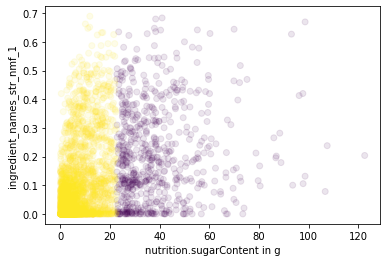

In [121]:
# let's explore what the clusters may reperesent => make scatter plots

import matplotlib.pyplot as plt

x_value = 'ingredient_names_str_nmf_0'
y_value = 'ingredient_names_str_nmf_1' # nmf_1 is the cakey component

#df_for_cake_clust.plot.scatter(x_value, y_value, c=df_for_cake_clust['cluster_label'], a=0.1)

fig = plt.figure()
plt.scatter(x = df_for_cake_clust[x_value],
           y = df_for_cake_clust[y_value],
           alpha = 0.1,
           c = df_for_cake_clust['cluster_label'])
plt.xlabel(f'{x_value}')
plt.ylabel(f'{y_value}')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


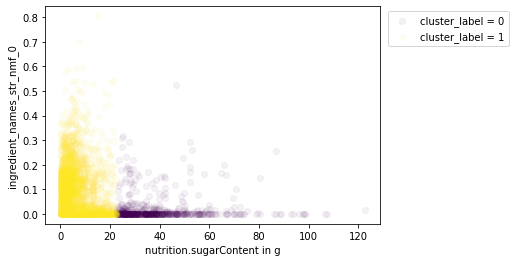

In [125]:
# let's explore what the clusters may reperesent => make scatter plots

import matplotlib.pyplot as plt

# nmf_1 is the cakey component
x_value = 'nutrition.sugarContent in g'
y_value = 'ingredient_names_str_nmf_0' 

x = df_for_cake_clust[x_value].tolist()
y = df_for_cake_clust[y_value].tolist()
classes = df_for_cake_clust['cluster_label'].tolist()

unique = list(set(classes))
colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    if u ==1:
        alpha = 0.05
    else:
        alpha = 0.05
    plt.scatter(xi, yi, c=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)
    
plt.xlabel(f'{x_value}')
plt.ylabel(f'{y_value}')
plt.legend(bbox_to_anchor=(1.4, 1))

plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


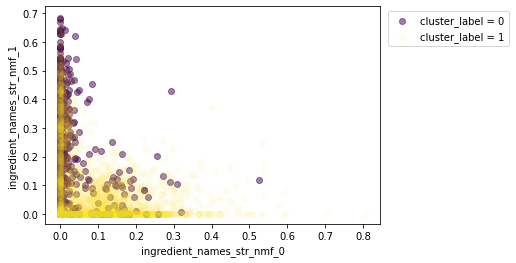

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


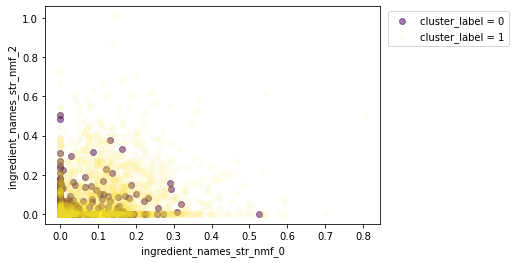

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


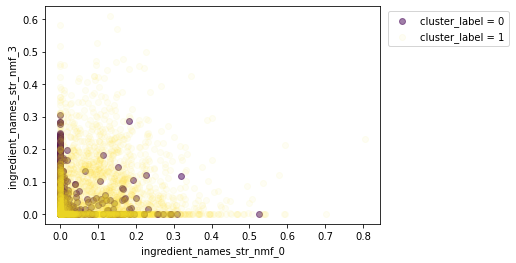

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


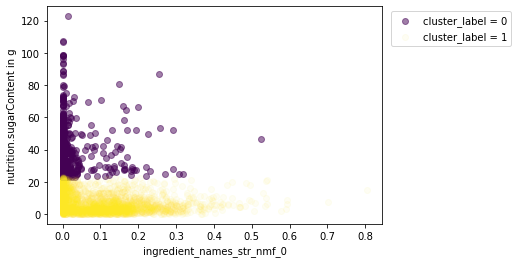

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


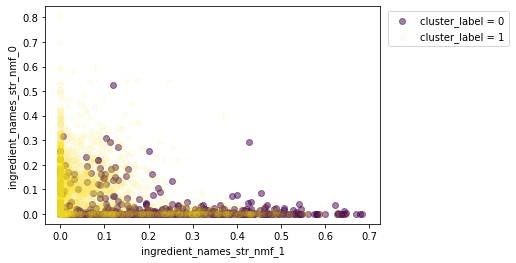

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


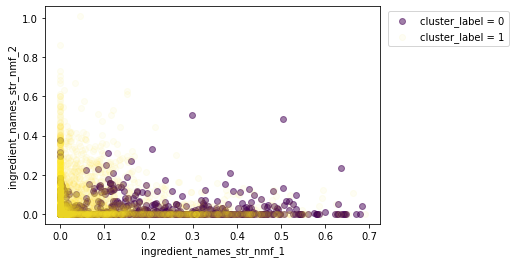

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


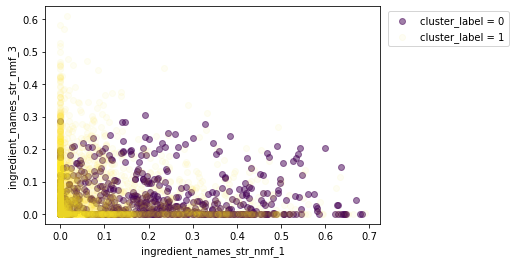

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


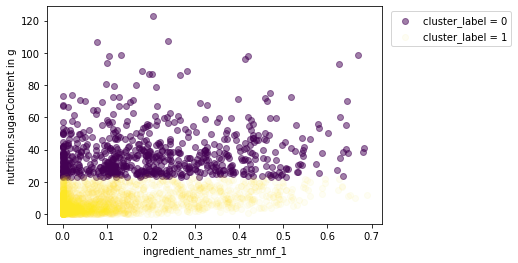

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


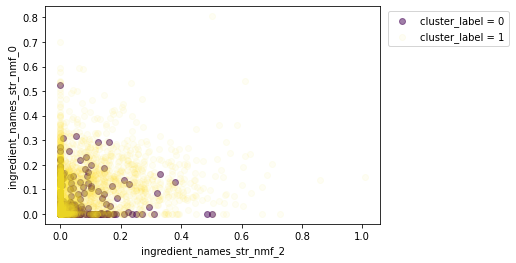

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


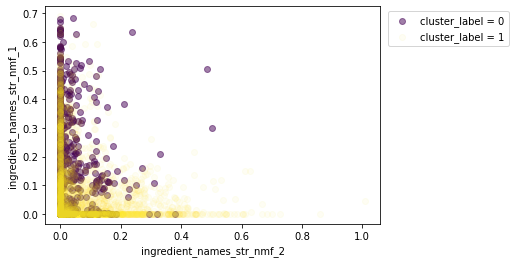

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


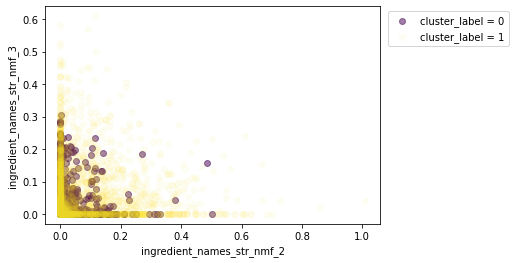

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


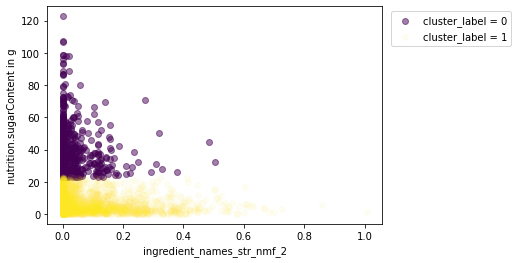

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


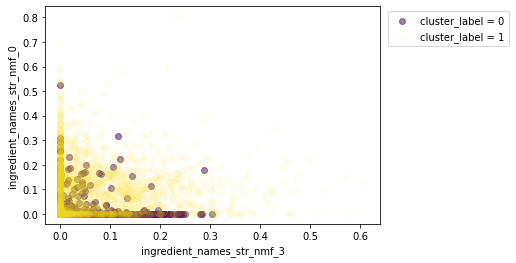

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


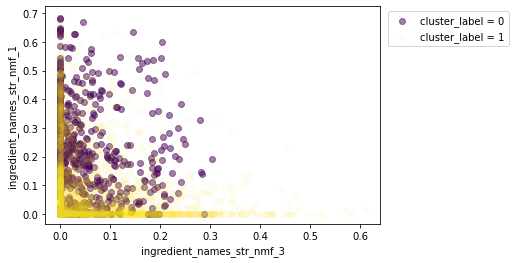

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


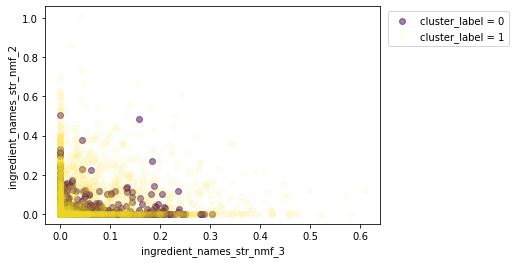

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


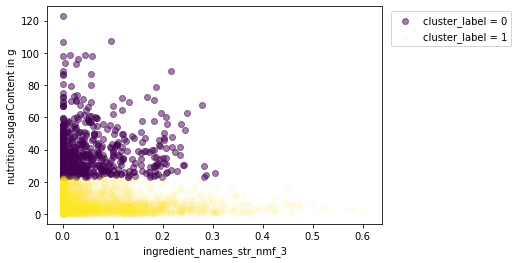

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


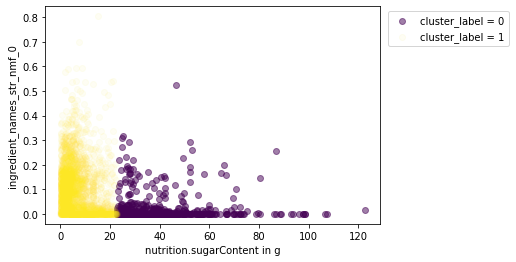

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


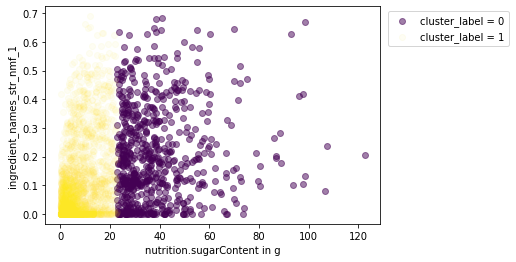

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


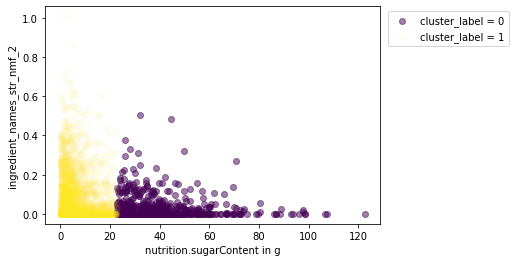

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


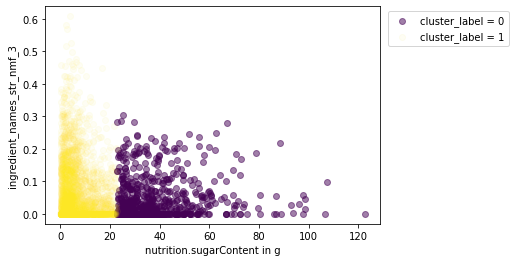

In [131]:
# let's explore what the clusters may reperesent => make scatter plots

import matplotlib.pyplot as plt

for col1 in selected_features:
    x = df_for_cake_clust[col1].tolist()
    for col2 in selected_features:
        if col2 != col1:
            y = df_for_cake_clust[col2].tolist()

            classes = df_for_cake_clust['cluster_label'].tolist()

            unique = list(set(classes))
            colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
            for i, u in enumerate(unique):
                xi = [x[j] for j  in range(len(x)) if classes[j] == u]
                yi = [y[j] for j  in range(len(x)) if classes[j] == u]
                if u ==1:
                    alpha = 0.05
                else:
                    alpha = 0.5
                plt.scatter(xi, yi, c=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)

            plt.xlabel(f'{col1}')
            plt.ylabel(f'{col2}')
            plt.legend(bbox_to_anchor=(1.4, 1))

            plt.show()

In [48]:
# split data into train & test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_for_cake_clust.loc[:, df_for_cake_clust.columns != 'avg_rating'], df_for_cake_clust['avg_rating'], random_state=0)